In [1]:
import logging
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import model_transformer
import anomaly_detection
from utils import SignalDataset
from interface import train

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler

In [2]:
def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

In [3]:
def known_anomalies(anomalies_list):
    found = list()
    for i in range(len(anomalies_list)):
        if anomalies_list[i] == 1:
            found.append(i)
    return found
        

In [4]:
def plot(dfs, anomalies=[]):   
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]
        
    df = dfs[0]
    time = convert_date(df['timestamp'])
    anomalies_data = []
    if 'anomaly' in df.columns:
        anomalies_data = known_anomalies(df['anomaly'])

    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)

    for df in dfs:
        plt.plot(time, df['signal'])
    
    for a_f in anomalies_data:
        plt.axvline(time[a_f], color='r', alpha=0.02)

    plt.title('Dataset', size=34)
    plt.ylabel('value', size=30)
    plt.xlabel('Time', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([time[0], time[-1]])
    
    plt.show()

In [5]:
#plot signal shape
temperature_data = pd.read_csv('./datasets/machine_temperature_system_failure.csv')
temperature_data['timestamp'] = pd.to_datetime(temperature_data['timestamp'])
temperature_data['timestamp'] = temperature_data['timestamp'].apply(lambda x: (x-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
temperature_data = temperature_data.rename(columns={"value": "signal"})
temperature_data['anomaly'] = 0
min_max_scaler = MinMaxScaler()
temperature_data[['signal']] = min_max_scaler.fit_transform(temperature_data[["signal"]])
temperature_data = temperature_data[:5000]
print(temperature_data.head())
print(temperature_data.info())
temperature_data.to_csv('./datasets/temperature_prepared.csv', index=False)

    timestamp    signal  anomaly
0  1386018900  0.675424        0
1  1386019200  0.684525        0
2  1386019500  0.695691        0
3  1386019800  0.714638        0
4  1386020100  0.725812        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5000 non-null   int64  
 1   signal     5000 non-null   float64
 2   anomaly    5000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 117.3 KB
None


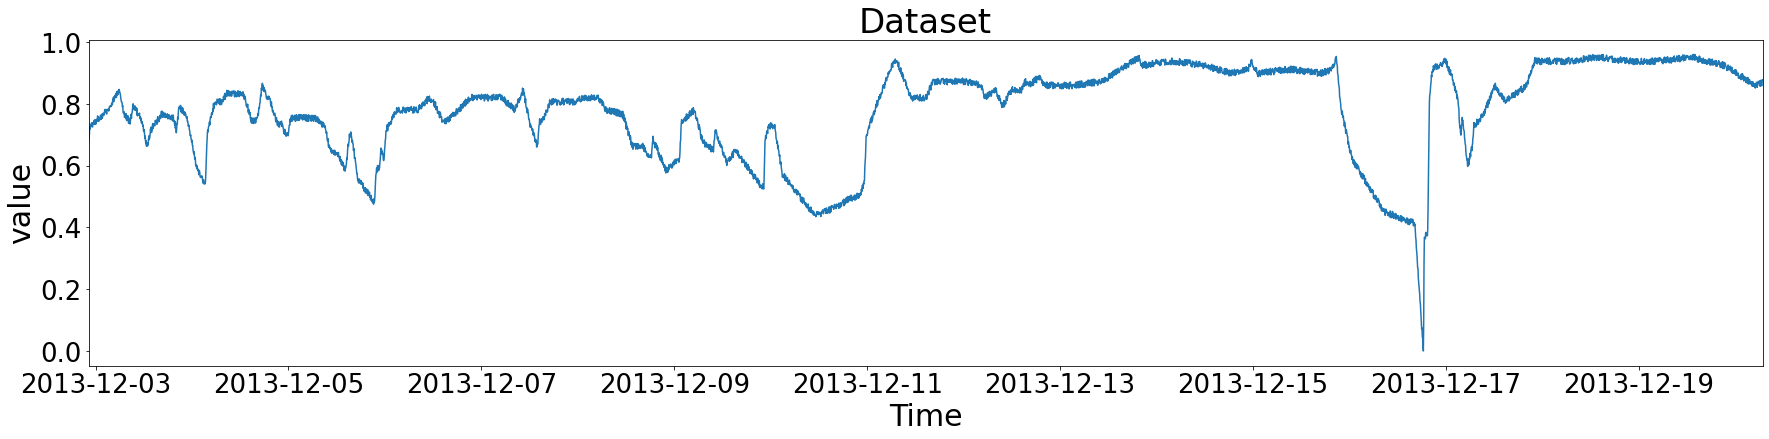

In [6]:
plot(temperature_data)

In [7]:
train_dataset = SignalDataset(path=f'./datasets/temperature_prepared.csv')

In [8]:
def critic_x_iteration(sample):
    optim_cx.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x)  # Wasserstein Loss

    # The sampled z are the anomalous points - points deviating from actual distribution of z (obtained through
    # encoding x)
    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)  # Wasserstein Loss

    alpha = torch.rand(x.shape)
    ix = Variable(alpha * x + (1 - alpha) * x_)  # Random Weighted Average
    ix.requires_grad_(True)
    v_ix = critic_x(ix)
    v_ix.mean().backward()
    gradients = ix.grad
    # Gradient Penalty Loss
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    # Critic has to maximize Cx(Valid X) - Cx(Fake X).
    # Maximizing the above is same as minimizing the negative.
    wl = critic_score_fake_x - critic_score_valid_x
    loss = wl + gp_loss
    loss.backward()
    optim_cx.step()

    return loss

In [9]:
def critic_z_iteration(sample):
    optim_cz.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z)  # Wasserstein Loss

    wl = critic_score_fake_z - critic_score_valid_z

    alpha = torch.rand(z.shape)
    iz = Variable(alpha * z + (1 - alpha) * z_)  # Random Weighted Average
    iz.requires_grad_(True)
    v_iz = critic_z(iz)
    v_iz.mean().backward()
    gradients = iz.grad
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    loss = wl + gp_loss
    loss.backward()
    optim_cz.step()

    return loss


In [10]:
def encoder_iteration(sample):
    optim_enc.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x)  # Wasserstein Loss

    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_enc = mse + critic_score_valid_x - critic_score_fake_x
    loss_enc.backward(retain_graph=True)
    optim_enc.step()

    return loss_enc

In [11]:
def decoder_iteration(sample):
    optim_dec.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_dec = mse + critic_score_valid_z - critic_score_fake_z
    loss_dec.backward(retain_graph=True)
    optim_dec.step()

    return loss_dec

In [12]:
def train(n_epochs=100):
    cx_epoch_loss = list()
    cz_epoch_loss = list()
    encoder_epoch_loss = list()
    decoder_epoch_loss = list()

    for epoch in range(n_epochs):
        n_critics = 5

        cx_nc_loss = list()
        cz_nc_loss = list()

        for i in range(n_critics):
            cx_loss = list()
            cz_loss = list()

            for batch, sample in tqdm(enumerate(train_loader)):
                loss = critic_x_iteration(sample)
                cx_loss.append(loss)

                loss = critic_z_iteration(sample)
                cz_loss.append(loss)

            cx_nc_loss.append(torch.mean(torch.tensor(cx_loss)))
            cz_nc_loss.append(torch.mean(torch.tensor(cz_loss)))

        encoder_loss = list()
        decoder_loss = list()

        for batch, sample in tqdm(enumerate(train_loader)):
            enc_loss = encoder_iteration(sample)
            dec_loss = decoder_iteration(sample)
            encoder_loss.append(enc_loss)
            decoder_loss.append(dec_loss)

        cx_epoch_loss.append(torch.mean(torch.tensor(cx_nc_loss)))
        cz_epoch_loss.append(torch.mean(torch.tensor(cz_nc_loss)))
        encoder_epoch_loss.append(torch.mean(torch.tensor(encoder_loss)))
        decoder_epoch_loss.append(torch.mean(torch.tensor(decoder_loss)))
        print("epoch", epoch)
        print('critic x loss {:.3f} critic z loss {:.3f} encoder loss {:.3f} decoder loss {:.3f}\n'.format(
            cx_epoch_loss[-1], cz_epoch_loss[-1], encoder_epoch_loss[-1], decoder_epoch_loss[-1]))
        

In [13]:
def evaluate(test_loader):

    reconstructed_unroll = []

    for batch, sample in tqdm(enumerate(train_loader)):
        reconstructed_signal = decoder(encoder(sample['signal']))
        reconstructed_signal = torch.squeeze(reconstructed_signal)
        median_values, median_indices = torch.median(reconstructed_signal, 1)
        median_values_list = median_values.tolist()
        reconstructed_unroll.extend(median_values_list)
    return np.asarray(reconstructed_unroll)


In [14]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)

lr = 1e-6

signal_shape = 100
latent_space_dim = 20

encoder = model_transformer.Encoder(signal_shape)
decoder = model_transformer.Decoder(signal_shape)
critic_x = model_transformer.CriticX(signal_shape)
critic_z = model_transformer.CriticZ()


mse_loss = torch.nn.MSELoss()

optim_enc = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_dec = optim.Adam(decoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cx = optim.Adam(critic_x.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cz = optim.Adam(critic_z.parameters(), lr=lr, betas=(0.5, 0.999))

train(n_epochs = 100)

76it [00:07, 10.41it/s]
76it [00:06, 10.97it/s]
76it [00:06, 12.15it/s]
76it [00:06, 10.91it/s]
76it [00:06, 11.83it/s]
76it [00:21,  3.53it/s]


epoch 0
critic x loss 0.784 critic z loss 0.904 encoder loss 0.344 decoder loss 0.196



76it [00:08,  9.35it/s]
76it [00:07, 10.24it/s]
76it [00:07,  9.85it/s]
76it [00:07,  9.75it/s]
76it [00:09,  8.34it/s]
76it [00:19,  3.80it/s]
0it [00:00, ?it/s]

epoch 1
critic x loss 0.720 critic z loss 0.978 encoder loss 0.322 decoder loss 0.035



76it [00:08,  9.33it/s]
76it [00:07,  9.98it/s]
76it [00:07,  9.63it/s]
76it [00:08,  9.32it/s]
76it [00:08,  8.64it/s]
76it [00:17,  4.34it/s]
1it [00:00,  8.98it/s]

epoch 2
critic x loss 0.662 critic z loss 1.065 encoder loss 0.302 decoder loss -0.138



76it [00:08,  9.13it/s]
76it [00:08,  9.42it/s]
76it [00:08,  9.28it/s]
76it [00:07,  9.86it/s]
76it [00:08,  9.29it/s]
76it [00:13,  5.57it/s]
1it [00:00,  9.08it/s]

epoch 3
critic x loss 0.604 critic z loss 1.149 encoder loss 0.279 decoder loss -0.283



76it [00:08,  8.84it/s]
76it [00:09,  7.99it/s]
76it [00:08,  9.29it/s]
76it [00:08,  8.52it/s]
76it [00:08,  9.12it/s]
76it [00:13,  5.69it/s]
1it [00:00,  9.20it/s]

epoch 4
critic x loss 0.547 critic z loss 1.209 encoder loss 0.280 decoder loss -0.391



76it [00:10,  7.45it/s]
76it [00:08,  8.90it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.33it/s]
76it [00:10,  7.43it/s]
76it [00:15,  5.06it/s]
1it [00:00,  7.90it/s]

epoch 5
critic x loss 0.491 critic z loss 1.241 encoder loss 0.309 decoder loss -0.436



76it [00:08,  8.51it/s]
76it [00:08,  8.57it/s]
76it [00:10,  7.30it/s]
76it [00:08,  9.16it/s]
76it [00:07, 10.03it/s]
76it [00:12,  6.24it/s]
0it [00:00, ?it/s]

epoch 6
critic x loss 0.434 critic z loss 1.258 encoder loss 0.344 decoder loss -0.467



76it [00:07, 10.75it/s]
76it [00:06, 10.95it/s]
76it [00:07, 10.21it/s]
76it [00:08,  9.31it/s]
76it [00:08,  8.61it/s]
76it [00:11,  6.37it/s]
2it [00:00, 11.05it/s]

epoch 7
critic x loss 0.379 critic z loss 1.264 encoder loss 0.386 decoder loss -0.490



76it [00:07, 10.83it/s]
76it [00:07, 10.76it/s]
76it [00:06, 11.10it/s]
76it [00:07, 10.71it/s]
76it [00:06, 11.14it/s]
76it [00:12,  6.03it/s]
2it [00:00, 11.24it/s]

epoch 8
critic x loss 0.325 critic z loss 1.264 encoder loss 0.423 decoder loss -0.493



76it [00:06, 10.95it/s]
76it [00:06, 11.04it/s]
76it [00:06, 11.25it/s]
76it [00:06, 11.40it/s]
76it [00:06, 11.28it/s]
76it [00:11,  6.55it/s]
2it [00:00, 11.24it/s]

epoch 9
critic x loss 0.271 critic z loss 1.261 encoder loss 0.465 decoder loss -0.512



76it [00:06, 11.01it/s]
76it [00:06, 10.87it/s]
76it [00:06, 11.10it/s]
76it [00:06, 10.96it/s]
76it [00:06, 11.08it/s]
76it [00:11,  6.57it/s]
2it [00:00, 10.81it/s]

epoch 10
critic x loss 0.218 critic z loss 1.255 encoder loss 0.515 decoder loss -0.507



76it [00:06, 11.17it/s]
76it [00:06, 11.35it/s]
76it [00:06, 10.90it/s]
76it [00:06, 11.20it/s]
76it [00:06, 10.93it/s]
76it [00:11,  6.45it/s]
2it [00:00, 11.49it/s]

epoch 11
critic x loss 0.166 critic z loss 1.252 encoder loss 0.552 decoder loss -0.512



76it [00:06, 11.01it/s]
76it [00:07, 10.77it/s]
76it [00:07, 10.44it/s]
76it [00:06, 11.16it/s]
76it [00:06, 10.96it/s]
76it [00:12,  6.24it/s]
1it [00:00,  9.71it/s]

epoch 12
critic x loss 0.115 critic z loss 1.244 encoder loss 0.599 decoder loss -0.515



76it [00:07, 10.75it/s]
76it [00:06, 11.30it/s]
76it [00:06, 10.93it/s]
76it [00:06, 11.04it/s]
76it [00:07, 10.79it/s]
76it [00:11,  6.49it/s]
0it [00:00, ?it/s]

epoch 13
critic x loss 0.064 critic z loss 1.235 encoder loss 0.640 decoder loss -0.513



76it [00:07, 10.84it/s]
76it [00:08,  9.33it/s]
76it [00:09,  8.15it/s]
76it [00:08,  8.52it/s]
76it [00:08,  8.96it/s]
76it [00:14,  5.29it/s]
2it [00:00, 10.93it/s]

epoch 14
critic x loss 0.015 critic z loss 1.230 encoder loss 0.687 decoder loss -0.509



76it [00:07, 10.22it/s]
76it [00:07,  9.94it/s]
76it [00:09,  8.19it/s]
76it [00:07, 10.74it/s]
76it [00:06, 10.99it/s]
76it [00:11,  6.42it/s]
0it [00:00, ?it/s]

epoch 15
critic x loss -0.035 critic z loss 1.224 encoder loss 0.730 decoder loss -0.510



76it [00:09,  8.43it/s]
76it [00:08,  8.47it/s]
76it [00:08,  8.65it/s]
76it [00:08,  8.55it/s]
76it [00:08,  9.28it/s]
76it [00:16,  4.65it/s]
1it [00:00,  6.62it/s]

epoch 16
critic x loss -0.087 critic z loss 1.219 encoder loss 0.775 decoder loss -0.506



76it [00:09,  8.32it/s]
76it [00:08,  9.35it/s]
76it [00:07, 10.60it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.67it/s]
76it [00:13,  5.53it/s]
0it [00:00, ?it/s]

epoch 17
critic x loss -0.136 critic z loss 1.211 encoder loss 0.820 decoder loss -0.501



76it [00:07,  9.64it/s]
76it [00:07, 10.80it/s]
76it [00:07, 10.45it/s]
76it [00:07, 10.25it/s]
76it [00:09,  8.02it/s]
76it [00:13,  5.55it/s]
1it [00:00,  7.58it/s]

epoch 18
critic x loss -0.184 critic z loss 1.203 encoder loss 0.868 decoder loss -0.504



76it [00:08,  9.46it/s]
76it [00:07, 10.33it/s]
76it [00:08,  9.04it/s]
76it [00:07,  9.59it/s]
76it [00:07,  9.68it/s]
76it [00:13,  5.66it/s]
0it [00:00, ?it/s]

epoch 19
critic x loss -0.233 critic z loss 1.194 encoder loss 0.909 decoder loss -0.498



76it [00:10,  7.59it/s]
76it [00:09,  8.17it/s]
76it [00:07,  9.60it/s]
76it [00:08,  8.59it/s]
76it [00:08,  9.40it/s]
76it [00:12,  6.28it/s]
0it [00:00, ?it/s]

epoch 20
critic x loss -0.283 critic z loss 1.186 encoder loss 0.960 decoder loss -0.493



76it [00:07, 10.28it/s]
76it [00:07, 10.38it/s]
76it [00:07,  9.60it/s]
76it [00:09,  8.22it/s]
76it [00:07,  9.61it/s]
76it [00:13,  5.45it/s]
1it [00:00,  9.90it/s]

epoch 21
critic x loss -0.330 critic z loss 1.178 encoder loss 1.002 decoder loss -0.492



76it [00:08,  8.76it/s]
76it [00:08,  9.11it/s]
76it [00:07,  9.94it/s]
76it [00:07,  9.64it/s]
76it [00:07,  9.73it/s]
76it [00:12,  6.13it/s]
1it [00:00,  9.90it/s]

epoch 22
critic x loss -0.379 critic z loss 1.173 encoder loss 1.047 decoder loss -0.495



76it [00:08,  9.45it/s]
76it [00:07,  9.94it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.17it/s]
76it [00:16,  4.62it/s]
1it [00:00,  6.21it/s]

epoch 23
critic x loss -0.427 critic z loss 1.166 encoder loss 1.090 decoder loss -0.487



76it [00:08,  9.30it/s]
76it [00:08,  9.46it/s]
76it [00:09,  8.35it/s]
76it [00:08,  9.05it/s]
76it [00:09,  7.84it/s]
76it [00:14,  5.12it/s]
1it [00:00,  9.80it/s]

epoch 24
critic x loss -0.475 critic z loss 1.161 encoder loss 1.135 decoder loss -0.486



76it [00:08,  9.20it/s]
76it [00:08,  8.92it/s]
76it [00:08,  9.37it/s]
76it [00:07,  9.99it/s]
76it [00:08,  8.59it/s]
76it [00:14,  5.10it/s]
1it [00:00,  9.90it/s]

epoch 25
critic x loss -0.523 critic z loss 1.153 encoder loss 1.179 decoder loss -0.474



76it [00:08,  9.13it/s]
76it [00:08,  8.56it/s]
76it [00:08,  8.98it/s]
76it [00:08,  9.50it/s]
76it [00:07, 10.02it/s]
76it [00:14,  5.33it/s]
1it [00:00,  9.71it/s]

epoch 26
critic x loss -0.570 critic z loss 1.144 encoder loss 1.226 decoder loss -0.478



76it [00:07,  9.53it/s]
76it [00:07, 10.03it/s]
76it [00:07,  9.87it/s]
76it [00:07,  9.64it/s]
76it [00:08,  9.36it/s]
76it [00:13,  5.70it/s]
0it [00:00, ?it/s]

epoch 27
critic x loss -0.619 critic z loss 1.141 encoder loss 1.266 decoder loss -0.473



76it [00:08,  9.44it/s]
76it [00:08,  9.37it/s]
76it [00:07,  9.82it/s]
76it [00:08,  8.52it/s]
76it [00:08,  9.15it/s]
76it [00:15,  5.04it/s]
0it [00:00, ?it/s]

epoch 28
critic x loss -0.664 critic z loss 1.133 encoder loss 1.313 decoder loss -0.471



76it [00:08,  8.77it/s]
76it [00:08,  8.83it/s]
76it [00:07,  9.71it/s]
76it [00:09,  8.27it/s]
76it [00:08,  8.67it/s]
76it [00:15,  4.83it/s]
0it [00:00, ?it/s]

epoch 29
critic x loss -0.711 critic z loss 1.126 encoder loss 1.357 decoder loss -0.466



76it [00:09,  8.15it/s]
76it [00:08,  8.94it/s]
76it [00:07, 10.34it/s]
76it [00:08,  9.37it/s]
76it [00:08,  9.32it/s]
76it [00:15,  4.97it/s]
1it [00:00,  8.93it/s]

epoch 30
critic x loss -0.758 critic z loss 1.117 encoder loss 1.401 decoder loss -0.454



76it [00:08,  8.95it/s]
76it [00:07,  9.80it/s]
76it [00:07,  9.99it/s]
76it [00:07, 10.48it/s]
76it [00:07, 10.33it/s]
76it [00:14,  5.20it/s]
0it [00:00, ?it/s]

epoch 31
critic x loss -0.804 critic z loss 1.106 encoder loss 1.445 decoder loss -0.453



76it [00:09,  8.20it/s]
76it [00:08,  9.30it/s]
76it [00:07, 10.69it/s]
76it [00:07,  9.71it/s]
76it [00:07,  9.70it/s]
76it [00:15,  4.85it/s]
1it [00:00,  6.33it/s]

epoch 32
critic x loss -0.851 critic z loss 1.105 encoder loss 1.491 decoder loss -0.459



76it [00:08,  8.60it/s]
76it [00:08,  8.95it/s]
76it [00:09,  8.19it/s]
76it [00:08,  9.42it/s]
76it [00:07, 10.19it/s]
76it [00:12,  5.99it/s]
2it [00:00, 10.64it/s]

epoch 33
critic x loss -0.897 critic z loss 1.100 encoder loss 1.531 decoder loss -0.444



76it [00:07,  9.68it/s]
76it [00:08,  8.87it/s]
76it [00:09,  8.22it/s]
76it [00:08,  8.94it/s]
76it [00:08,  8.85it/s]
76it [00:14,  5.30it/s]
1it [00:00,  9.43it/s]

epoch 34
critic x loss -0.942 critic z loss 1.093 encoder loss 1.574 decoder loss -0.450



76it [00:08,  9.25it/s]
76it [00:07,  9.75it/s]
76it [00:08,  9.11it/s]
76it [00:07, 10.35it/s]
76it [00:07, 10.50it/s]
76it [00:12,  6.00it/s]
2it [00:00, 10.87it/s]

epoch 35
critic x loss -0.987 critic z loss 1.088 encoder loss 1.617 decoder loss -0.447



76it [00:07, 10.27it/s]
76it [00:07,  9.92it/s]
76it [00:07, 10.20it/s]
76it [00:07, 10.55it/s]
76it [00:08,  9.07it/s]
76it [00:13,  5.56it/s]
1it [00:00,  8.13it/s]

epoch 36
critic x loss -1.031 critic z loss 1.084 encoder loss 1.664 decoder loss -0.445



76it [00:07,  9.60it/s]
76it [00:08,  8.61it/s]
76it [00:09,  8.36it/s]
76it [00:08,  9.04it/s]
76it [00:08,  8.53it/s]
76it [00:15,  4.98it/s]
1it [00:00,  6.54it/s]

epoch 37
critic x loss -1.079 critic z loss 1.079 encoder loss 1.706 decoder loss -0.440



76it [00:08,  8.76it/s]
76it [00:08,  8.54it/s]
76it [00:08,  9.34it/s]
76it [00:07,  9.72it/s]
76it [00:08,  8.62it/s]
76it [00:13,  5.74it/s]
1it [00:00,  9.35it/s]

epoch 38
critic x loss -1.123 critic z loss 1.075 encoder loss 1.749 decoder loss -0.442



76it [00:07,  9.94it/s]
76it [00:09,  8.43it/s]
76it [00:08,  8.57it/s]
76it [00:08,  8.83it/s]
76it [00:07,  9.53it/s]
76it [00:14,  5.30it/s]
0it [00:00, ?it/s]

epoch 39
critic x loss -1.169 critic z loss 1.071 encoder loss 1.796 decoder loss -0.439



76it [00:08,  8.98it/s]
76it [00:08,  8.81it/s]
76it [00:08,  9.21it/s]
76it [00:08,  8.95it/s]
76it [00:09,  8.41it/s]
76it [00:12,  5.85it/s]
1it [00:00,  9.43it/s]

epoch 40
critic x loss -1.211 critic z loss 1.065 encoder loss 1.842 decoder loss -0.431



76it [00:08,  8.66it/s]
76it [00:07,  9.83it/s]
76it [00:07,  9.96it/s]
76it [00:08,  9.11it/s]
76it [00:07,  9.62it/s]
76it [00:13,  5.53it/s]
0it [00:00, ?it/s]

epoch 41
critic x loss -1.259 critic z loss 1.061 encoder loss 1.881 decoder loss -0.432



76it [00:07,  9.54it/s]
76it [00:07,  9.71it/s]
76it [00:07, 10.54it/s]
76it [00:07, 10.18it/s]
76it [00:08,  9.28it/s]
76it [00:14,  5.18it/s]
0it [00:00, ?it/s]

epoch 42
critic x loss -1.303 critic z loss 1.057 encoder loss 1.927 decoder loss -0.430



76it [00:09,  8.23it/s]
76it [00:08,  8.76it/s]
76it [00:07,  9.56it/s]
76it [00:08,  8.88it/s]
76it [00:07,  9.68it/s]
76it [00:13,  5.65it/s]
1it [00:00,  9.62it/s]

epoch 43
critic x loss -1.347 critic z loss 1.053 encoder loss 1.969 decoder loss -0.427



76it [00:07,  9.65it/s]
76it [00:07,  9.57it/s]
76it [00:07, 10.38it/s]
76it [00:07, 10.09it/s]
76it [00:07,  9.84it/s]
76it [00:13,  5.61it/s]
1it [00:00,  8.93it/s]

epoch 44
critic x loss -1.392 critic z loss 1.047 encoder loss 2.012 decoder loss -0.433



76it [00:07, 10.37it/s]
76it [00:07, 10.28it/s]
76it [00:07, 10.35it/s]
76it [00:07, 10.34it/s]
76it [00:07, 10.37it/s]
76it [00:13,  5.64it/s]
1it [00:00,  9.52it/s]

epoch 45
critic x loss -1.436 critic z loss 1.049 encoder loss 2.057 decoder loss -0.429



76it [00:07, 10.46it/s]
76it [00:07, 10.32it/s]
76it [00:07,  9.72it/s]
76it [00:07,  9.89it/s]
76it [00:07, 10.47it/s]
76it [00:13,  5.49it/s]
0it [00:00, ?it/s]

epoch 46
critic x loss -1.481 critic z loss 1.046 encoder loss 2.102 decoder loss -0.427



76it [00:08,  9.47it/s]
76it [00:07,  9.89it/s]
76it [00:08,  9.49it/s]
76it [00:08,  9.07it/s]
76it [00:09,  8.26it/s]
76it [00:16,  4.50it/s]
1it [00:00,  8.20it/s]

epoch 47
critic x loss -1.529 critic z loss 1.044 encoder loss 2.139 decoder loss -0.423



76it [00:07,  9.83it/s]
76it [00:07, 10.15it/s]
76it [00:07, 10.55it/s]
76it [00:07, 10.21it/s]
76it [00:08,  8.76it/s]
76it [00:14,  5.22it/s]
2it [00:00, 11.24it/s]

epoch 48
critic x loss -1.569 critic z loss 1.036 encoder loss 2.187 decoder loss -0.425



76it [00:09,  8.42it/s]
76it [00:08,  8.86it/s]
76it [00:08,  9.17it/s]
76it [00:08,  8.57it/s]
76it [00:07, 10.11it/s]
76it [00:14,  5.31it/s]
1it [00:00,  9.71it/s]

epoch 49
critic x loss -1.614 critic z loss 1.033 encoder loss 2.232 decoder loss -0.420



76it [00:07,  9.64it/s]
76it [00:08,  8.48it/s]
76it [00:09,  8.03it/s]
76it [00:07,  9.51it/s]
76it [00:07, 10.22it/s]
76it [00:14,  5.32it/s]
2it [00:00, 10.58it/s]

epoch 50
critic x loss -1.656 critic z loss 1.028 encoder loss 2.266 decoder loss -0.416



76it [00:07, 10.56it/s]
76it [00:07, 10.38it/s]
76it [00:07, 10.21it/s]
76it [00:07,  9.82it/s]
76it [00:08,  9.39it/s]
76it [00:15,  4.98it/s]
0it [00:00, ?it/s]

epoch 51
critic x loss -1.702 critic z loss 1.024 encoder loss 2.311 decoder loss -0.416



76it [00:07,  9.76it/s]
76it [00:08,  9.23it/s]
76it [00:08,  8.75it/s]
76it [00:07,  9.91it/s]
76it [00:07, 10.20it/s]
76it [00:13,  5.44it/s]
0it [00:00, ?it/s]

epoch 52
critic x loss -1.742 critic z loss 1.021 encoder loss 2.352 decoder loss -0.417



76it [00:08,  8.61it/s]
76it [00:07,  9.71it/s]
76it [00:07,  9.61it/s]
76it [00:08,  8.96it/s]
76it [00:08,  9.15it/s]
76it [00:15,  5.01it/s]
1it [00:00,  9.52it/s]

epoch 53
critic x loss -1.789 critic z loss 1.018 encoder loss 2.395 decoder loss -0.421



76it [00:07,  9.89it/s]
76it [00:07,  9.65it/s]
76it [00:08,  9.26it/s]
76it [00:08,  9.23it/s]
76it [00:08,  8.93it/s]
76it [00:13,  5.70it/s]
0it [00:00, ?it/s]

epoch 54
critic x loss -1.830 critic z loss 1.018 encoder loss 2.438 decoder loss -0.411



76it [00:07,  9.56it/s]
76it [00:07,  9.95it/s]
76it [00:09,  8.38it/s]
76it [00:09,  8.32it/s]
76it [00:08,  8.57it/s]
76it [00:16,  4.57it/s]
1it [00:00,  7.41it/s]

epoch 55
critic x loss -1.871 critic z loss 1.011 encoder loss 2.482 decoder loss -0.410



76it [00:09,  7.81it/s]
76it [00:08,  9.20it/s]
76it [00:07,  9.51it/s]
76it [00:08,  9.41it/s]
76it [00:08,  8.62it/s]
76it [00:15,  4.97it/s]
0it [00:00, ?it/s]

epoch 56
critic x loss -1.917 critic z loss 1.006 encoder loss 2.525 decoder loss -0.411



76it [00:08,  9.04it/s]
76it [00:10,  6.98it/s]
76it [00:08,  9.34it/s]
76it [00:08,  8.75it/s]
76it [00:08,  8.88it/s]
76it [00:13,  5.61it/s]
1it [00:00,  6.71it/s]

epoch 57
critic x loss -1.961 critic z loss 1.003 encoder loss 2.566 decoder loss -0.404



76it [00:08,  8.83it/s]
76it [00:08,  8.69it/s]
76it [00:08,  9.24it/s]
76it [00:07,  9.63it/s]
76it [00:09,  8.29it/s]
76it [00:13,  5.60it/s]
0it [00:00, ?it/s]

epoch 58
critic x loss -2.003 critic z loss 1.001 encoder loss 2.602 decoder loss -0.407



76it [00:07, 10.19it/s]
76it [00:07, 10.20it/s]
76it [00:08,  8.99it/s]
76it [00:09,  8.43it/s]
76it [00:08,  9.27it/s]
76it [00:15,  4.96it/s]
1it [00:00,  8.93it/s]

epoch 59
critic x loss -2.044 critic z loss 1.000 encoder loss 2.649 decoder loss -0.410



76it [00:07,  9.57it/s]
76it [00:08,  8.55it/s]
76it [00:08,  9.34it/s]
76it [00:08,  9.14it/s]
76it [00:09,  7.91it/s]
76it [00:15,  4.96it/s]
1it [00:00,  7.81it/s]

epoch 60
critic x loss -2.090 critic z loss 0.993 encoder loss 2.692 decoder loss -0.401



76it [00:09,  7.99it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.82it/s]
76it [00:08,  9.44it/s]
76it [00:14,  5.18it/s]
1it [00:00,  8.20it/s]

epoch 61
critic x loss -2.132 critic z loss 0.991 encoder loss 2.733 decoder loss -0.402



76it [00:08,  8.59it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.75it/s]
76it [00:08,  9.38it/s]
76it [00:08,  9.39it/s]
76it [00:14,  5.14it/s]
1it [00:00,  8.40it/s]

epoch 62
critic x loss -2.173 critic z loss 0.988 encoder loss 2.776 decoder loss -0.402



76it [00:08,  8.93it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.26it/s]
76it [00:08,  8.98it/s]
76it [00:08,  8.56it/s]
76it [00:14,  5.10it/s]
1it [00:00,  8.70it/s]

epoch 63
critic x loss -2.219 critic z loss 0.984 encoder loss 2.820 decoder loss -0.402



76it [00:09,  8.40it/s]
76it [00:09,  8.40it/s]
76it [00:08,  8.83it/s]
76it [00:08,  8.48it/s]
76it [00:08,  8.83it/s]
76it [00:15,  5.01it/s]
1it [00:00,  9.62it/s]

epoch 64
critic x loss -2.260 critic z loss 0.984 encoder loss 2.856 decoder loss -0.400



76it [00:09,  7.95it/s]
76it [00:08,  8.95it/s]
76it [00:08,  9.26it/s]
76it [00:08,  8.72it/s]
76it [00:09,  7.88it/s]
76it [00:16,  4.70it/s]
1it [00:00,  7.52it/s]

epoch 65
critic x loss -2.306 critic z loss 0.982 encoder loss 2.901 decoder loss -0.400



76it [00:10,  7.49it/s]
76it [00:09,  8.03it/s]
76it [00:09,  8.00it/s]
76it [00:08,  9.13it/s]
76it [00:08,  8.96it/s]
76it [00:15,  4.94it/s]
1it [00:00,  5.99it/s]

epoch 66
critic x loss -2.347 critic z loss 0.976 encoder loss 2.945 decoder loss -0.397



76it [00:09,  7.78it/s]
76it [00:08,  9.09it/s]
76it [00:08,  8.93it/s]
76it [00:08,  9.13it/s]
76it [00:08,  8.87it/s]
76it [00:17,  4.34it/s]
1it [00:00,  9.01it/s]

epoch 67
critic x loss -2.386 critic z loss 0.976 encoder loss 2.989 decoder loss -0.397



76it [00:08,  9.05it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.33it/s]
76it [00:08,  9.01it/s]
76it [00:08,  9.27it/s]
76it [00:15,  5.05it/s]
1it [00:00,  8.77it/s]

epoch 68
critic x loss -2.430 critic z loss 0.970 encoder loss 3.027 decoder loss -0.396



76it [00:08,  8.95it/s]
76it [00:08,  9.09it/s]
76it [00:08,  8.59it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.54it/s]
76it [00:17,  4.35it/s]
1it [00:00,  9.80it/s]

epoch 69
critic x loss -2.471 critic z loss 0.970 encoder loss 3.072 decoder loss -0.396



76it [00:08,  8.60it/s]
76it [00:08,  9.15it/s]
76it [00:08,  8.86it/s]
76it [00:08,  9.33it/s]
76it [00:08,  9.22it/s]
76it [00:15,  4.90it/s]
1it [00:00,  9.09it/s]

epoch 70
critic x loss -2.509 critic z loss 0.965 encoder loss 3.113 decoder loss -0.391



76it [00:08,  8.51it/s]
76it [00:08,  9.00it/s]
76it [00:08,  9.06it/s]
76it [00:08,  8.86it/s]
76it [00:08,  8.87it/s]
76it [00:15,  5.02it/s]
1it [00:00,  7.69it/s]

epoch 71
critic x loss -2.558 critic z loss 0.962 encoder loss 3.150 decoder loss -0.393



76it [00:08,  8.52it/s]
76it [00:09,  7.61it/s]
76it [00:11,  6.83it/s]
76it [00:10,  7.37it/s]
76it [00:09,  7.89it/s]
76it [00:16,  4.64it/s]
1it [00:00,  8.70it/s]

epoch 72
critic x loss -2.602 critic z loss 0.960 encoder loss 3.194 decoder loss -0.394



76it [00:09,  7.60it/s]
76it [00:08,  8.90it/s]
76it [00:09,  8.27it/s]
76it [00:09,  8.21it/s]
76it [00:09,  8.22it/s]
76it [00:15,  4.94it/s]
1it [00:00,  8.47it/s]

epoch 73
critic x loss -2.640 critic z loss 0.958 encoder loss 3.234 decoder loss -0.393



76it [00:08,  9.20it/s]
76it [00:08,  9.10it/s]
76it [00:08,  9.03it/s]
76it [00:08,  8.50it/s]
76it [00:08,  9.12it/s]
76it [00:17,  4.35it/s]
1it [00:00,  8.20it/s]

epoch 74
critic x loss -2.684 critic z loss 0.953 encoder loss 3.277 decoder loss -0.391



76it [00:10,  7.54it/s]
76it [00:08,  8.56it/s]
76it [00:08,  9.07it/s]
76it [00:08,  8.75it/s]
76it [00:09,  7.76it/s]
76it [00:15,  4.94it/s]
1it [00:00,  7.25it/s]

epoch 75
critic x loss -2.726 critic z loss 0.954 encoder loss 3.322 decoder loss -0.386



76it [00:08,  8.99it/s]
76it [00:08,  8.87it/s]
76it [00:08,  9.16it/s]
76it [00:08,  8.88it/s]
76it [00:08,  8.99it/s]
76it [00:15,  4.93it/s]
1it [00:00,  8.93it/s]

epoch 76
critic x loss -2.762 critic z loss 0.951 encoder loss 3.359 decoder loss -0.392



76it [00:09,  7.67it/s]
76it [00:08,  8.99it/s]
76it [00:08,  9.06it/s]
76it [00:08,  9.23it/s]
76it [00:09,  8.08it/s]
76it [00:16,  4.48it/s]
1it [00:00,  8.26it/s]

epoch 77
critic x loss -2.815 critic z loss 0.949 encoder loss 3.407 decoder loss -0.393



76it [00:08,  8.61it/s]
76it [00:08,  8.82it/s]
76it [00:08,  8.75it/s]
76it [00:08,  8.76it/s]
76it [00:08,  8.63it/s]
76it [00:15,  4.88it/s]
1it [00:00,  8.26it/s]

epoch 78
critic x loss -2.856 critic z loss 0.946 encoder loss 3.444 decoder loss -0.385



76it [00:08,  8.91it/s]
76it [00:09,  8.31it/s]
76it [00:10,  7.13it/s]
76it [00:09,  8.04it/s]
76it [00:09,  8.09it/s]
76it [00:16,  4.63it/s]
1it [00:00,  9.62it/s]

epoch 79
critic x loss -2.897 critic z loss 0.948 encoder loss 3.489 decoder loss -0.386



76it [00:08,  9.11it/s]
76it [00:08,  8.85it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.89it/s]
76it [00:15,  4.98it/s]
1it [00:00,  9.17it/s]

epoch 80
critic x loss -2.937 critic z loss 0.941 encoder loss 3.530 decoder loss -0.387



76it [00:08,  9.13it/s]
76it [00:08,  8.92it/s]
76it [00:08,  9.02it/s]
76it [00:08,  8.98it/s]
76it [00:08,  9.08it/s]
76it [00:17,  4.44it/s]
1it [00:00,  9.80it/s]

epoch 81
critic x loss -2.982 critic z loss 0.942 encoder loss 3.569 decoder loss -0.387



76it [00:09,  7.98it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.90it/s]
76it [00:08,  8.80it/s]
76it [00:08,  8.92it/s]
76it [00:15,  4.88it/s]
1it [00:00,  8.55it/s]

epoch 82
critic x loss -3.026 critic z loss 0.940 encoder loss 3.616 decoder loss -0.393



76it [00:08,  8.63it/s]
76it [00:08,  8.73it/s]
76it [00:08,  8.58it/s]
76it [00:08,  8.89it/s]
76it [00:09,  8.36it/s]
76it [00:17,  4.31it/s]
1it [00:00,  7.52it/s]

epoch 83
critic x loss -3.068 critic z loss 0.938 encoder loss 3.656 decoder loss -0.385



76it [00:11,  6.77it/s]
76it [00:09,  8.33it/s]
76it [00:08,  8.57it/s]
76it [00:08,  8.68it/s]
76it [00:08,  8.71it/s]
76it [00:15,  4.81it/s]
1it [00:00,  8.77it/s]

epoch 84
critic x loss -3.109 critic z loss 0.935 encoder loss 3.700 decoder loss -0.386



76it [00:08,  8.72it/s]
76it [00:08,  8.84it/s]
76it [00:08,  8.74it/s]
76it [00:08,  8.89it/s]
76it [00:08,  8.77it/s]
76it [00:15,  4.81it/s]
0it [00:00, ?it/s]

epoch 85
critic x loss -3.153 critic z loss 0.932 encoder loss 3.744 decoder loss -0.386



76it [00:08,  8.83it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.84it/s]
76it [00:08,  8.85it/s]
76it [00:08,  8.86it/s]
76it [00:15,  4.83it/s]
1it [00:00,  8.93it/s]

epoch 86
critic x loss -3.195 critic z loss 0.934 encoder loss 3.782 decoder loss -0.389



76it [00:08,  9.00it/s]
76it [00:08,  8.59it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.77it/s]
76it [00:08,  8.97it/s]
76it [00:15,  4.80it/s]
1it [00:00,  6.25it/s]

epoch 87
critic x loss -3.237 critic z loss 0.931 encoder loss 3.822 decoder loss -0.377



76it [00:09,  8.30it/s]
76it [00:09,  8.32it/s]
76it [00:08,  8.60it/s]
76it [00:08,  8.84it/s]
76it [00:08,  8.81it/s]
76it [00:15,  4.76it/s]
1it [00:00,  9.17it/s]

epoch 88
critic x loss -3.277 critic z loss 0.929 encoder loss 3.866 decoder loss -0.387



76it [00:09,  8.32it/s]
76it [00:08,  8.79it/s]
76it [00:08,  8.59it/s]
76it [00:08,  8.68it/s]
76it [00:08,  8.64it/s]
76it [00:15,  4.76it/s]
1it [00:00,  9.01it/s]

epoch 89
critic x loss -3.320 critic z loss 0.924 encoder loss 3.911 decoder loss -0.383



76it [00:08,  8.66it/s]
76it [00:08,  8.87it/s]
76it [00:08,  8.59it/s]
76it [00:08,  8.93it/s]
76it [00:08,  8.85it/s]
76it [00:15,  4.79it/s]
1it [00:00,  8.55it/s]

epoch 90
critic x loss -3.363 critic z loss 0.926 encoder loss 3.947 decoder loss -0.388



76it [00:08,  8.66it/s]
76it [00:08,  8.69it/s]
76it [00:08,  8.75it/s]
76it [00:08,  8.74it/s]
76it [00:08,  8.88it/s]
76it [00:15,  4.76it/s]
1it [00:00,  9.52it/s]

epoch 91
critic x loss -3.407 critic z loss 0.922 encoder loss 3.992 decoder loss -0.383



76it [00:08,  8.78it/s]
76it [00:08,  8.56it/s]
76it [00:08,  8.78it/s]
76it [00:08,  8.63it/s]
76it [00:08,  8.80it/s]
76it [00:15,  4.76it/s]
1it [00:00,  8.55it/s]

epoch 92
critic x loss -3.448 critic z loss 0.916 encoder loss 4.039 decoder loss -0.390



76it [00:08,  8.68it/s]
76it [00:08,  8.63it/s]
76it [00:08,  8.60it/s]
76it [00:08,  8.59it/s]
76it [00:08,  8.78it/s]
76it [00:16,  4.70it/s]
1it [00:00,  8.33it/s]

epoch 93
critic x loss -3.488 critic z loss 0.914 encoder loss 4.080 decoder loss -0.379



76it [00:08,  8.68it/s]
76it [00:08,  8.73it/s]
76it [00:08,  8.66it/s]
76it [00:08,  8.72it/s]
76it [00:08,  8.57it/s]
76it [00:16,  4.71it/s]
1it [00:00,  9.09it/s]

epoch 94
critic x loss -3.526 critic z loss 0.911 encoder loss 4.116 decoder loss -0.382



76it [00:09,  8.35it/s]
76it [00:08,  8.59it/s]
76it [00:09,  8.44it/s]
76it [00:08,  8.46it/s]
76it [00:08,  8.47it/s]
76it [00:16,  4.72it/s]
1it [00:00,  8.00it/s]

epoch 95
critic x loss -3.573 critic z loss 0.912 encoder loss 4.163 decoder loss -0.388



76it [00:08,  8.57it/s]
76it [00:08,  8.59it/s]
76it [00:08,  8.61it/s]
76it [00:08,  8.66it/s]
76it [00:08,  8.57it/s]
76it [00:16,  4.71it/s]
1it [00:00,  9.71it/s]

epoch 96
critic x loss -3.610 critic z loss 0.905 encoder loss 4.198 decoder loss -0.376



76it [00:08,  8.70it/s]
76it [00:08,  8.61it/s]
76it [00:08,  8.89it/s]
76it [00:08,  8.59it/s]
76it [00:08,  8.72it/s]
76it [00:15,  4.76it/s]
1it [00:00,  9.52it/s]

epoch 97
critic x loss -3.654 critic z loss 0.904 encoder loss 4.239 decoder loss -0.379



76it [00:08,  8.65it/s]
76it [00:08,  8.58it/s]
76it [00:08,  8.77it/s]
76it [00:08,  8.71it/s]
76it [00:08,  8.65it/s]
76it [00:16,  4.67it/s]
1it [00:00,  9.17it/s]

epoch 98
critic x loss -3.695 critic z loss 0.906 encoder loss 4.281 decoder loss -0.374



76it [00:08,  8.60it/s]
76it [00:08,  8.66it/s]
76it [00:08,  8.72it/s]
76it [00:08,  8.55it/s]
76it [00:08,  8.69it/s]
76it [00:16,  4.69it/s]


epoch 99
critic x loss -3.737 critic z loss 0.902 encoder loss 4.322 decoder loss -0.372



In [15]:
reconstructed_data = evaluate(train_loader)
reconstructed_data

76it [00:05, 12.73it/s]


array([0.30013502, 0.32587984, 0.36168894, ..., 0.29495454, 0.29635066,
       0.28879291])

In [16]:
print(len(reconstructed_data))

4864


In [17]:
x_values = np.arange(start=0, stop=len(reconstructed_data), step=1)
print(len(x_values))

4864


In [18]:
signal_to_compare = temperature_data['signal'][:len(reconstructed_data)]

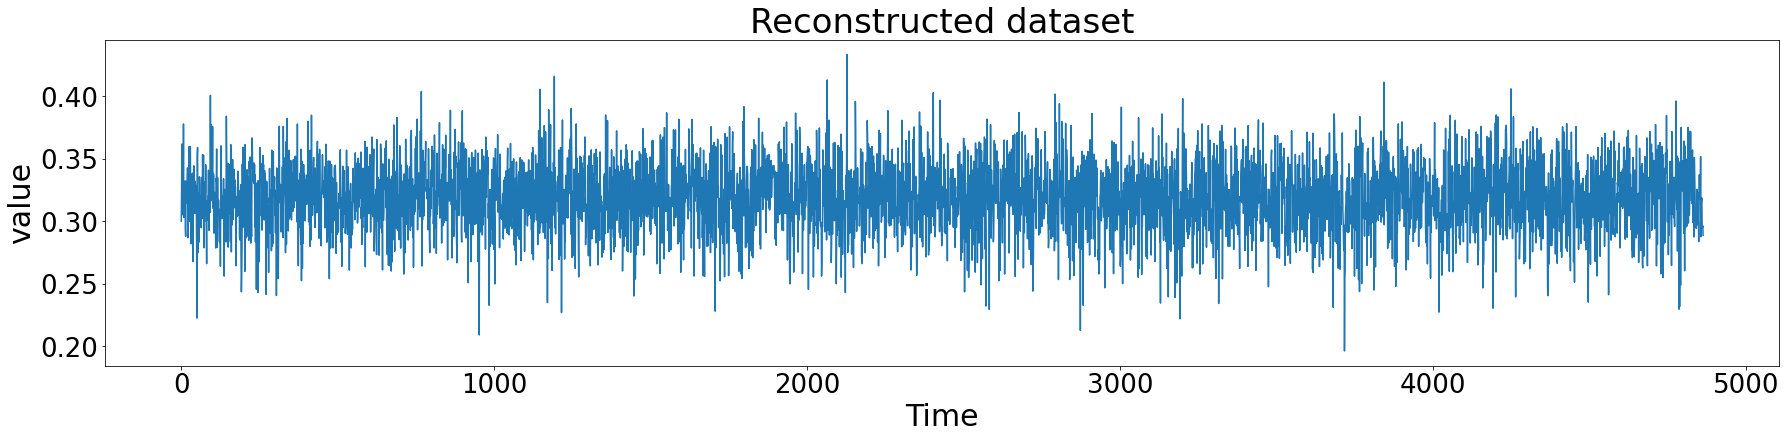

In [19]:
fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

plt.plot(x_values, reconstructed_data)

plt.title('Reconstructed dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
    
plt.show()

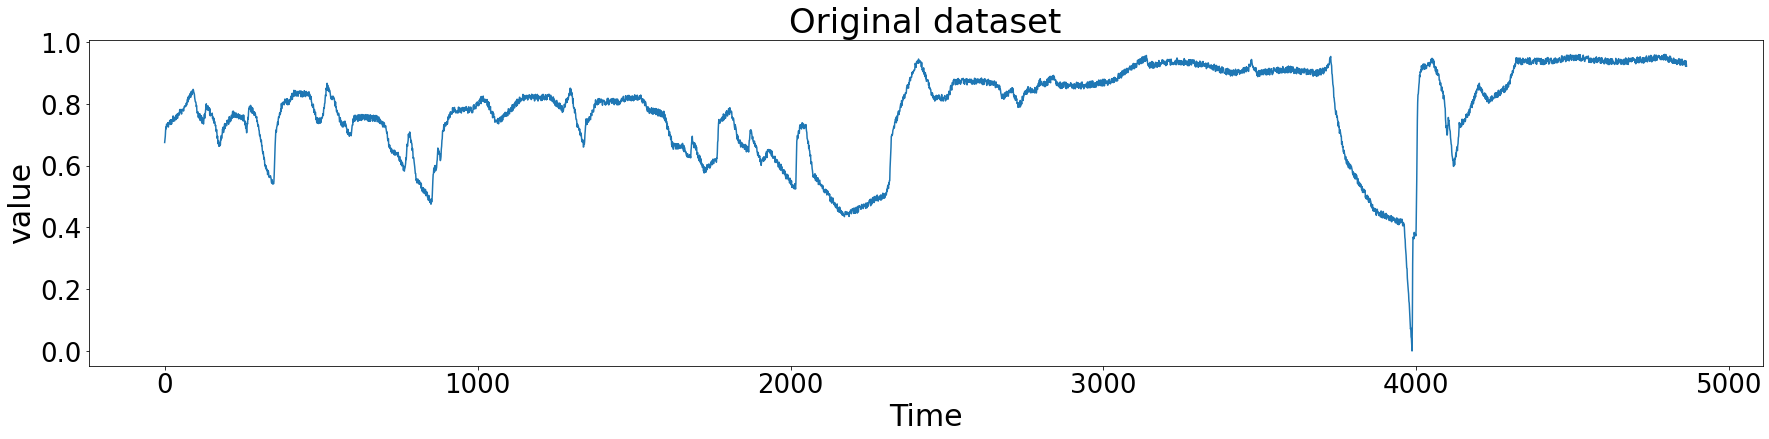

In [20]:
fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

plt.plot(x_values, signal_to_compare)

plt.title('Original dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
    
plt.show()